Aluno: Guilherme de Oliveira Mendes
Matrícula:180113496

## Objetive

Build a model that can differentiate 

## Downloading the main components

In [1]:
!pip install -Uqq fastai fastbook duckduckgo_search gradio

In [2]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [3]:
from fastai.vision.all import *
import gradio as gr
import timm

## 

## Doewnloading the images and creating the DataBlock

After checking and Downloading all the requirements to create the model, the images that are going to be used in the model are downloaded and separated by their classification in this case Medieval, Samurai and Greek-Roman, in this model it is being used a sample of 250 of each of the three types of armor. 

In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep


def search_images1(term, max_images=250):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')


searches = 'Medieval','Samurai','Greek-Roman'
path = Path('armors')
if not path.exists():
    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images1(f'{o} armor'))
        sleep(10)
        resize_images(path/o, max_size=400, dest=path/o)

After finished the download of the images it is necessarry to check for any failures and remove them or the model will not work

In [5]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

After that all the working images are put in the DataBlock

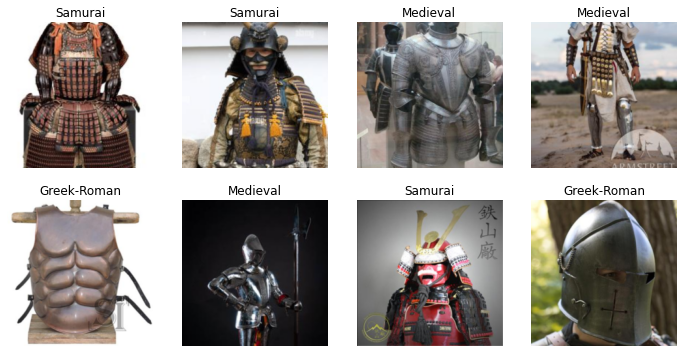

In [6]:
armors = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224))
dls = armors.dataloaders(path)
dls.show_batch(max_n=8)

Normally just rezising all images to the same size is necessary to train the model but such process will either deform the image or leave wasted space, in this case it is better to just change angles or inclination of the image, since to the model this will actually help to better understant the concept of what the object is and how to indentify a image of it, like in the way you can see in the two examples below

In [7]:
armors = armors.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = armors.dataloaders(path)

## Creating the model and improving it

After this is done the model is created and then fine-tuned do minimize error rate

In [74]:
learn = vision_learner(dls,resnet34, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.631145,0.813168,0.310606,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.591131,0.473939,0.204545,00:08
1,0.485734,0.410725,0.151515,00:08
2,0.371768,0.423692,0.113636,00:08
3,0.297261,0.385384,0.113636,00:07


After the model is done it is exported as model.pkl so that it can be used futher

In [9]:
learn.export('model1.pkl')

After it is exported, a image will be chosen and used as a base to see how the neural net works

## Showing the parameters of the model created

In [18]:
def search_images(term, max_images=1):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [32]:
urls = search_images('Samurai Armor', max_images=1)
urls[0]

Searching for 'Samurai Armor'


'https://www.samuraimuseum.jp/shop/wp-content/uploads/2020/05/IMG_4770-scaled.jpg'

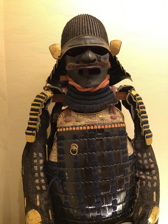

In [35]:
im =PILImage.create('Samurai.jpg')
im.thumbnail((224,224))
im


In [25]:
learn = load_learner('model1.pkl')

In [37]:
learn.predict(im)

('Samurai', TensorBase(2), TensorBase([7.1060e-06, 1.3093e-06, 9.9999e-01]))

theses numbers above show the probablity of this image being one of the 3 categories in this case: knight,greek-roman and samurai

In [39]:
categories= learn.dls.vocab

def classify_image(img):
    pred,index,probs = learn.predict(img)
    return dict(zip(categories,map(float,probs)))


In [40]:
classify_image(im)

{'Greek-Roman': 7.105951681296574e-06,
 'Medieval': 1.309260596826789e-06,
 'Samurai': 0.9999915361404419}

Bellow is Showw the model that has been trained, showing all of its layers and their connection betwwen each other

In [41]:
m = learn.model
m

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

for example he it is the parameters of the layer 0 and other layer also called 0 that makes part of the first layer 0

In [54]:
l = m.get_submodule('0.0')
list(l.parameters())

[Parameter containing:
 tensor([[[[ 5.3621e-03, -6.9587e-03,  7.8311e-03,  ...,  4.9016e-02,
             3.0594e-02,  2.5326e-02],
           [ 4.1051e-02,  3.1257e-02,  3.2219e-02,  ...,  3.3103e-02,
             2.9699e-02,  4.1677e-02],
           [ 4.9186e-03, -3.1749e-02, -6.1359e-02,  ..., -9.7532e-02,
            -1.1606e-01, -1.2197e-01],
           ...,
           [-1.2317e-02, -2.4877e-02, -9.3490e-03,  ...,  1.7082e-02,
             2.4227e-03,  1.6684e-02],
           [ 3.8891e-03,  4.4239e-03,  3.6274e-02,  ...,  1.0368e-01,
             7.3937e-02,  5.9048e-02],
           [ 1.6761e-02,  8.8588e-03,  3.1273e-02,  ...,  9.6934e-02,
             8.3710e-02,  9.6930e-02]],
 
          [[-7.7418e-03, -8.7969e-03,  1.4114e-02,  ...,  3.3866e-02,
             2.5440e-02,  2.4226e-02],
           [ 5.3964e-02,  4.4667e-02,  3.4309e-02,  ...,  1.3374e-02,
             1.9108e-02,  3.7965e-02],
           [ 1.0209e-03, -5.4531e-02, -1.0227e-01,  ..., -1.9232e-01,
            -1.9

another example showing the parameters of the layer 0 par of the layer 4 which is part of the layer 0

In [55]:
l = m.get_submodule('0.4.0.conv2')
list(l.parameters())

[Parameter containing:
 tensor([[[[ 0.0656, -0.0101,  0.0405],
           [ 0.0334, -0.0550,  0.0170],
           [ 0.0291,  0.0646,  0.0698]],
 
          [[-0.0176,  0.0514, -0.0388],
           [-0.0042, -0.0646, -0.0077],
           [ 0.0342, -0.1004,  0.0355]],
 
          [[-0.0085, -0.0356, -0.0473],
           [-0.0124,  0.0253,  0.0044],
           [ 0.0166,  0.0285,  0.0076]],
 
          ...,
 
          [[ 0.0019, -0.0456, -0.0270],
           [ 0.0114, -0.0143,  0.0236],
           [ 0.0141,  0.0109,  0.0376]],
 
          [[ 0.0160,  0.0154,  0.0018],
           [ 0.0060, -0.0281, -0.0123],
           [ 0.0308, -0.0054, -0.0086]],
 
          [[-0.0007, -0.0075, -0.0101],
           [-0.0361,  0.0162,  0.0215],
           [ 0.0353,  0.0239,  0.0123]]],
 
 
         [[[ 0.0083,  0.0239, -0.0043],
           [ 0.0109,  0.0443,  0.0028],
           [-0.0119,  0.0092, -0.0009]],
 
          [[ 0.0103,  0.0064, -0.0006],
           [ 0.0103, -0.0028,  0.0040],
           [ 0.0

## how a model works

the parameters used in the creation of layer to diffentiate images, for this is necessary a infinite flexible function, such function can be created using rectified linear function


In [63]:

from ipywidgets import interact
from fastai.basics import *

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)


it is made initially using a linear function

the code above creates the function and cahnges any number bellow 1 to 0

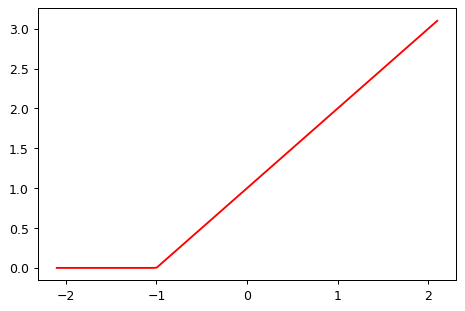

In [70]:
def rectified_linear(m,b,x):
    y = m*x+b
    return torch.clip(y, 0.)
plot_function(partial(rectified_linear, 1,1))

The m control the slope of the graph and b the intersection of shift

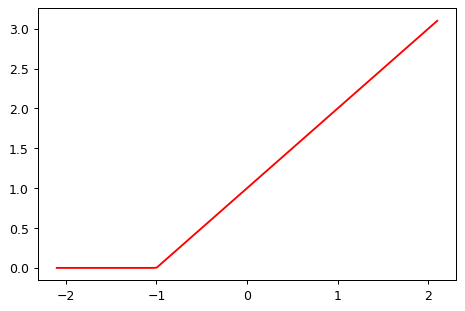

In [71]:
import torch.nn.functional as F
def rectified_linear2(m,b,x): return F.relu(m*x+b)
plot_function(partial(rectified_linear2, 1,1))

In [72]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m,b), ylim=(-1,4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

The m control the slope of the graph and b the intersection of shift

the function can be added to another function  and this can be done as many times as necessary

In [73]:
def double_relu(m1,b1,m2,b2,x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(-1,6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

with this method a model can be created a precise model with enough data and parameters